In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import re

### 1. A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el número de nodos y aristas. Haga una representación gráfica del grafo.

In [3]:
# data = []
# with open('data.csv', 'rw') as archivo:
#     for row in archivo:
#         data.append(list(map(lambda x: x.lower(), row.split(', ')[:4])))
    
# df = pd.DataFrame(data, columns=['year','opcode', 'field', 'authors'])
# df.to_pickle('data.df')
df = pd.read_pickle('data.df')
df.head(10)

,year,opcode,field,authors
0,1992,b368,nucl.phys.,horne & horowitz
1,1992,b278,phys. lett.,mikovic
2,1991,a6,mod. phys. lett.,huitu & nemeschansky
3,1992,b373,nucl.phys.,witten
4,1991,a6,mod.phys.lett.,intriligator
5,1991,a6,mod. phys. lett.,ooguri & sasakura
6,1992,a7,int. j. mod. phys.,leclair & smirnov
7,1992,b372,nucl.phys.,griffin
8,1992,b274,phys. lett.,sen
9,1992,b372,nucl.phys.,lerche & smit & warner


In [4]:
def get_pares(lista):
    return [(lista[x],lista[y]) for x in range(len(lista)) for y in range(x+1,len(lista))]

In [5]:
nodos = []
for col in df.index:
    nodos += list(map(lambda x: re.sub(r'\W+', '', x), df.iloc[col].authors.split(" & ")))
nodos = set(nodos)
G = nx.MultiGraph()
G.add_nodes_from(nodos)
for col in df.index:
    a = list(map(lambda x: re.sub(r'\W+', '', x), df.iloc[col].authors.split(" & ")))
    G.add_edges_from(get_pares(a))

In [5]:
print 'Cantidad de nodos:', G.number_of_nodes()
print 'Cantidad de aristas:', G.number_of_edges()
# print G.nodes()
# print G.degree

Cantidad de nodos: 3943
Cantidad de aristas: 13205


In [6]:
def NodosEscalados(G, n_max):
    '''
    Dado un grafo devuelve un subgrafo de a lo sumo n_max nodos
    que intenta respetar las proporciones de los grados de los nodos
    en el grafo original (remueve nodos aislados).
    
    Input:
    G = grafo
    prop_por_grado[i]: nodos de grado[i] / nodos_en_grafo
    n_max: maxima cantidad de nodos que puede tener el subgrafo generado
    '''
    nodos_subgrafo = []
    
    degree_sequence = list(sorted(map(lambda x: x[1], nx.degree(G)), reverse=True))
    prop_por_grado = [x/float(G.number_of_nodes()) for x in degree_sequence]
    
    nodos_que_faltan = [int(x*n_max) for x in prop_por_grado]
    
    for (nodo, grado) in G.degree():
        if grado == 0:
            continue
        if nodos_que_faltan[grado] > 0:
            nodos_subgrafo.append(nodo)
            nodos_que_faltan[grado] -= 1
    
    return nodos_subgrafo

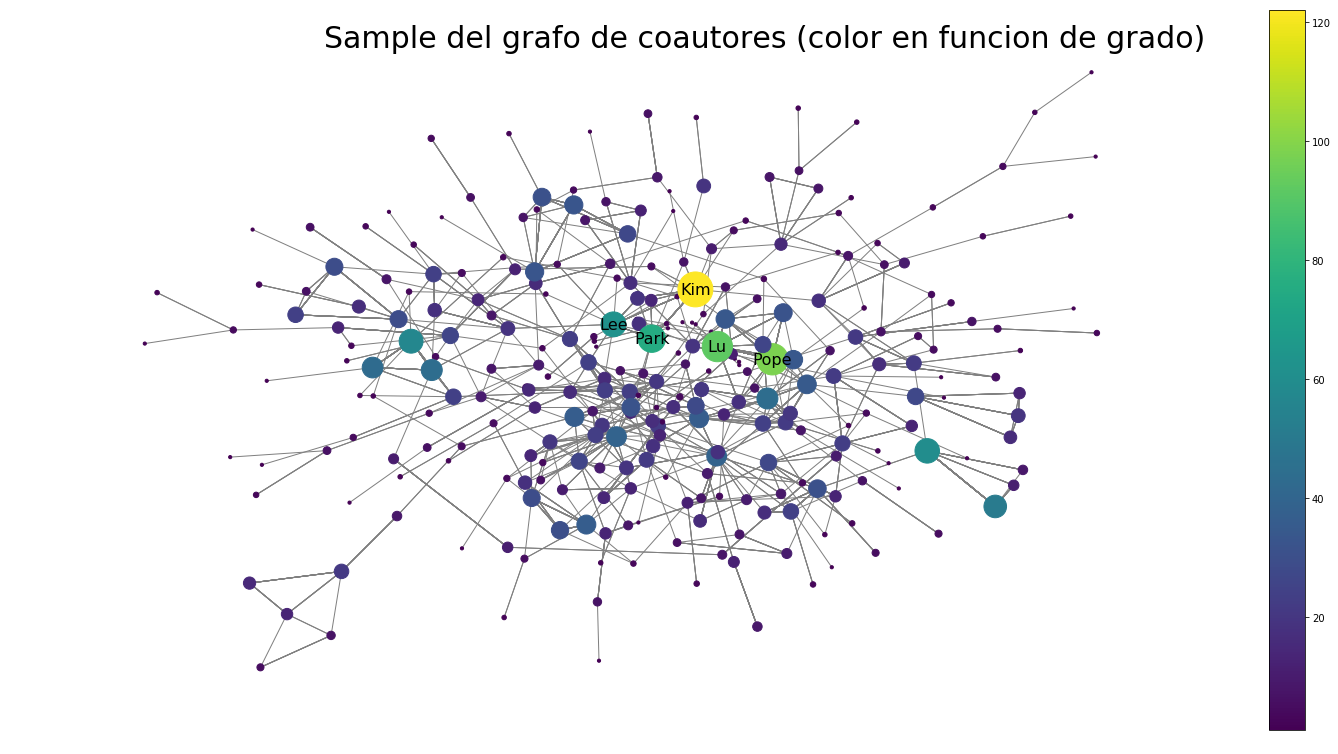

In [24]:
#Genero un subgrafo y saco los nodos con grado 0 en el subgrafo
subG = G.subgraph(NodosEscalados(G, 500))

#Filtro los nodos aislados en el subgrafo (no aportan al dibujo)
subG = G.subgraph(list(filter(lambda x: subG.degree(x)>0, subG.nodes())))
subG_grados = list((map(lambda x: x[1], nx.degree(subG))))
node_size = [x*10 for x in subG_grados]

labels = {}
for (nodo, grado) in subG.degree():
    if grado > 60:
        labels[nodo] = nodo.capitalize()
    else:
        labels[nodo] = ""
        
c_map = plt.cm.viridis
vmin = min(subG_grados)
vmax = max(subG_grados)

plt.clf()
fig = plt.figure(figsize=(20, 10))

nx.draw_kamada_kawai(subG, node_size=node_size, labels=labels, 
                     edge_color="grey", cmap=c_map, node_color=subG_grados, font_size=16)


sm = plt.cm.ScalarMappable(cmap=c_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)

fig.suptitle("Sample del grafo de coautores (color en funcion de grado)", fontsize=30)
plt.show()

### 2. Grafique la distribución del grado de los autores, en escalas lineales, semilogarítmica, y log-log. Argumente, a partir de los gráficos, de qué tipo de distribución se trata.

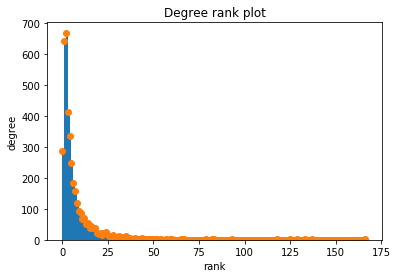

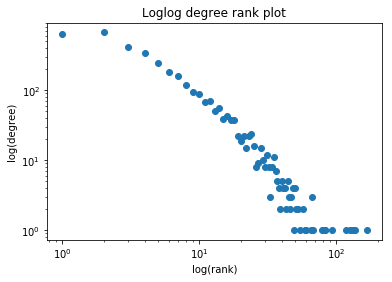

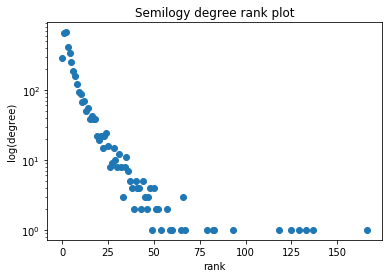

In [8]:
degree_sequence = list(sorted(map(lambda x: x[1], nx.degree(G)), reverse=True)) # degree sequence
bins = plt.hist(degree_sequence, bins=max(degree_sequence))
 
plt.plot(bins[0], 'o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

plt.loglog(bins[0], 'o')
plt.title("Loglog degree rank plot")
plt.ylabel("log(degree)")
plt.xlabel("log(rank)")
plt.show()

plt.semilogy(bins[0], 'o')
plt.title("Semilogy degree rank plot")
plt.ylabel("log(degree)")
plt.xlabel("rank")
plt.show()


# AGREGAR CONCLUSIONES

### 3. Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor, o componente gigante.


In [9]:
c_gigante_size, c_gigante_elems = sorted(list(map(lambda x: (len(x), x), nx.connected_components(G)))
                                        , reverse=True)[0]

print "Cantidad de componentes conexas del grafo: {}".format(nx.number_connected_components(G))
print "Tamaño de la componente gigante: {} nodos".format(c_gigante_size)

Cantidad de componentes conexas del grafo: 506
Tamaño de la componente gigante: 3026 nodos


### 4. Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, cómo aumenta el número de autores alcanzados a medida que se aleja del nodo semilla. Grafique el número de autores alcanzados en función de la distancia al nodo semilla. Grafique también el número de nuevos autores que se agregan en cada paso, y estime el máximo de esta función. Pruebe con varios nodos semillas y analice la robustez de este resultado. Discuta el significado de los gráficos y su relación con el fenómeno de seis grados de separación.

In [10]:
#Creo el grafo que es solo la componente gigante
G_gigante = G.subgraph(c_gigante_elems)